# Análisis de Consumo Energético y Clustering con Clustering Spectral

## Objetivos del Cuaderno

1. **Generación de Features Agregadas**: Crear nuevas características a partir de los datos originales para representar patrones de consumo de manera más significativa y reducir la dimensionalidad.
2. **Manejo de Valores Faltantes** (KNNImputer o SoftImpute)
3. **Escalado de Características** (`StandardScaler`)

4. **Selección del Número de Clusters (K)**: Probar diferentes metodos para obtener valores de K y determinar el número óptimo de clusters.
    - **Método del Codo**: Graficar la inercia en función de K y buscar el "codo" en la gráfica.
    - **Silhouette Score**: Calcular el coeficiente de silueta para diferentes valores de K y graficar los resultados.
    - **Davies-Bouldin Index**: Calcular el índice de Davies-Bouldin para diferentes valores de K y graficar los resultados.
    - **K-ISAC-TLP**: Utilizar el método K-ISAC-TLP para determinar el número óptimo de clusters.
        - **ISAC Curves**: Graficar las curvas ISAC para diferentes valores de K y observar la tendencia.
        - **MAE**: Calcular el error absoluto medio (MAE) para diferentes valores de K y graficar los resultados.
        - **Irrelevant clusters**: Identificar y eliminar clusters irrelevantes que no aporten información significativa.
5. **Clustering con Clustering Spectral**: Aplicar el algoritmo de Clustering Spectral para agrupar las viviendas en función de sus patrones de consumo energético.
6. **Validación del Modelo**: Evaluar la calidad de los clusters generados utilizando metedos y visualizaciones adecuadas.
    -  **Visualización de Clusters**: Graficar los clusters generados para observar la distribución de los datos y la separación entre los grupos
        - **Análisis de Componentes Principales (PCA)**: Para la visualizazacion 2D de los cluster

## Introducción

El dataset contiene información horaria del consumo energético de aproximadamente 130 viviendas durante un período de dos años. Cada registro incluye:
- **CUPS**: Identificador único de la vivienda.
- **Fecha**: Día específico del registro.
- **Hora**: Hora del día (1 a 24).
- **Consumo_kWh**: Consumo energético en kilovatios-hora.

Dado el volumen de datos, es necesario crear características agregadas que representen patrones de consumo a nivel diario, semanal, mensual, etc., para facilitar el análisis y el clustering.


## Preprocesamiento y Generación de Features

Antes de aplicar el clustering, comenzaremos con:
1. Preprocesamiento y Generación de Features
    - Justificación del Pipeline:
    El preprocesamiento sistemático es crítico porque:
        - **Consistencia**: Las estaciones y tipos de día (laborable/fin de semana) tienen patrones de consumo fundamentalmente distintos.
        - **Robustez**: Las métricas propuestas (percentiles, Lyapunov, FFT) capturan tanto comportamientos típicos como anomalías.
        - **Interpretabilidad**: La separación por contextos naturales (estaciones) facilita la acción sobre resultados.
2. **Creación de Features Agregadas**:
    **Subanálisis (por vivienda):**
    - Primavera
    - Verano
    - Otoño
    - Invierno
    - Análisis general

    **Dentro de cada subanálisis:**
    - Separar en:
    - Días laborables
    - Fines de semana

    **Métricas a calcular para cada parte:**
    | Variable                        | Descripción                                      |
    |---------------------------------|--------------------------------------------------|
    | Media y Desviación Estándar     | Tendencia central y dispersión                  |
    | Asimetría (Skewness)            | Simetría de la distribución                     |
    | Curtosis                        | Picudez/plenitud de la distribución             |
    | Energía (FFT)                   | Potencia acumulada de la señal                  |
    | Frecuencia dominante (FFT)      | Periodicidad más fuerte                         |
    | Mediana y percentiles (25, 75)  | Distribución robusta                            |

3. **Normalización de Datos**: Escalar las características para que todas tengan el mismo rango y no dominen el análisis.

Una vez que los datos estén preprocesados y las nuevas características estén listas, procederemos con la aplicación de K-Means y la evaluación de los resultados.

Imports

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import re
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import seaborn as sns
import random
import math
from sklearn.impute import KNNImputer
from fancyimpute import SoftImpute
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, mean_absolute_error, davies_bouldin_score
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../../../data/vertical_preprocessed_data_2.csv", sep=";")

Funciones

In [4]:
def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return 'invierno'
    elif mes in [3, 4, 5]:
        return 'primavera'
    elif mes in [6, 7, 8]:
        return 'verano'
    else:
        return 'otoño'


def calcular_features(consumos):
    consumos = np.array(consumos)
    if len(consumos) < 2:
        return dict.fromkeys([
            'media', 'std', 'skewness', 'kurtosis',
            'energia_fft', 'frecuencia_dominante',
            'mediana', 'p25', 'p75'
        ], np.nan)

    media = np.mean(consumos)
    std = np.std(consumos)
    skewness = skew(consumos)
    kurt = kurtosis(consumos)

    fft_vals = fft(consumos)
    fft_powers = np.abs(fft_vals)**2
    energia = np.sum(fft_powers) / len(fft_powers)
    frec_dom = np.argmax(fft_powers[1:]) + 1 if len(fft_powers) > 1 else np.nan

    return {
        'media': media,
        'std': std,
        'skewness': skewness,
        'kurtosis': kurt,
        'energia_fft': energia,
        'frecuencia_dominante': frec_dom,
        'mediana': np.median(consumos),
        'p25': np.percentile(consumos, 25),
        'p75': np.percentile(consumos, 75)
    }

In [5]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['hora'] = df['hora'].astype(int)
df['dia_semana'] = df['fecha'].dt.dayofweek
df['es_fin_de_semana'] = df['dia_semana'] >= 5
df['mes'] = df['fecha'].dt.month

df['estacion'] = df['mes'].apply(obtener_estacion)

df_grouped = df.groupby(['cups', 'fecha', 'estacion'])['consumo_kWh'].apply(list).reset_index()

# Diccionario donde las claves serán cups y los valores serán diccionarios de features
features_por_cups = {}

# 1. Subanálisis por estación (sin dividir por tipo de día)
for (cups, estacion), grupo in df_grouped.groupby(['cups', 'estacion']):
    consumos = sum(grupo['consumo_kWh'].tolist(), [])
    feats = calcular_features(consumos)
    prefix = f"{estacion}"

    if cups not in features_por_cups:
        features_por_cups[cups] = {}

    for key, val in feats.items():
        features_por_cups[cups][f"{key}_{prefix}"] = val

# 2. Subanálisis ANUAL completo (sin dividir) - Se mantiene igual
for cups, grupo in df_grouped.groupby('cups'):
    consumos = sum(grupo['consumo_kWh'].tolist(), [])
    feats = calcular_features(consumos)
    for key, val in feats.items():
        features_por_cups[cups][f"{key}_anual"] = val

df_features_final = pd.DataFrame.from_dict(features_por_cups, orient='index')
df_features_final.reset_index(inplace=True)
df_features_final.rename(columns={'index': 'cups'}, inplace=True)
df_features_final.set_index('cups', inplace=True)

In [6]:
# df['fecha'] = pd.to_datetime(df['fecha'])
# df['hora'] = df['hora'].astype(int)
# df['dia_semana'] = df['fecha'].dt.dayofweek
# df['es_fin_de_semana'] = df['dia_semana'] >= 5
# df['mes'] = df['fecha'].dt.month

# df['estacion'] = df['mes'].apply(obtener_estacion)

# df_grouped = df.groupby(['cups', 'fecha', 'es_fin_de_semana', 'estacion'])['consumo_kWh'].apply(list).reset_index()

# # Diccionario donde las claves serán cups y los valores serán diccionarios de features
# features_por_cups = {}

# # 1. Subanálisis por estación y tipo de día (laboral/finde)
# for (cups, estacion, es_finde), grupo in df_grouped.groupby(['cups', 'estacion', 'es_fin_de_semana']):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     tipo_dia = 'finde' if es_finde else 'laboral'
#     prefix = f"{estacion}_{tipo_dia}"
    
#     if cups not in features_por_cups:
#         features_por_cups[cups] = {}
    
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_{prefix}"] = val

# # 2. Subanálisis ANUAL dividido en laboral/finde
# for (cups, es_finde), grupo in df_grouped.groupby(['cups', 'es_fin_de_semana']):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     tipo_dia = 'finde' if es_finde else 'laboral'
#     prefix = f"anual_{tipo_dia}"  # Cambiado a "anual_laboral" y "anual_finde"
    
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_{prefix}"] = val

# # 3. Subanálisis ANUAL completo (sin dividir)
# for cups, grupo in df_grouped.groupby('cups'):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_anual"] = val  # Se mantiene igual

# df_features_final = pd.DataFrame.from_dict(features_por_cups, orient='index')
# df_features_final.reset_index(inplace=True)
# df_features_final.rename(columns={'index': 'cups'}, inplace=True)
# df_features_final.set_index('cups', inplace=True)

### Matriz de Correlación

Matriz de Correlación:
                                 media_invierno  std_invierno  \
media_invierno                        1.000000      0.840128   
std_invierno                          0.840128      1.000000   
skewness_invierno                    -0.645887     -0.544706   
kurtosis_invierno                    -0.493550     -0.480077   
energia_fft_invierno                  0.839330      0.874305   
frecuencia_dominante_invierno        -0.104640     -0.068603   
mediana_invierno                      0.866193      0.482343   
p25_invierno                          0.693958      0.280306   
p75_invierno                          0.948512      0.725276   
media_otoño                           0.880786      0.669790   
std_otoño                             0.877199      0.918304   
skewness_otoño                       -0.465249     -0.237981   
kurtosis_otoño                       -0.461140     -0.335243   
energia_fft_otoño                     0.861430      0.830564   
frecuencia_domin

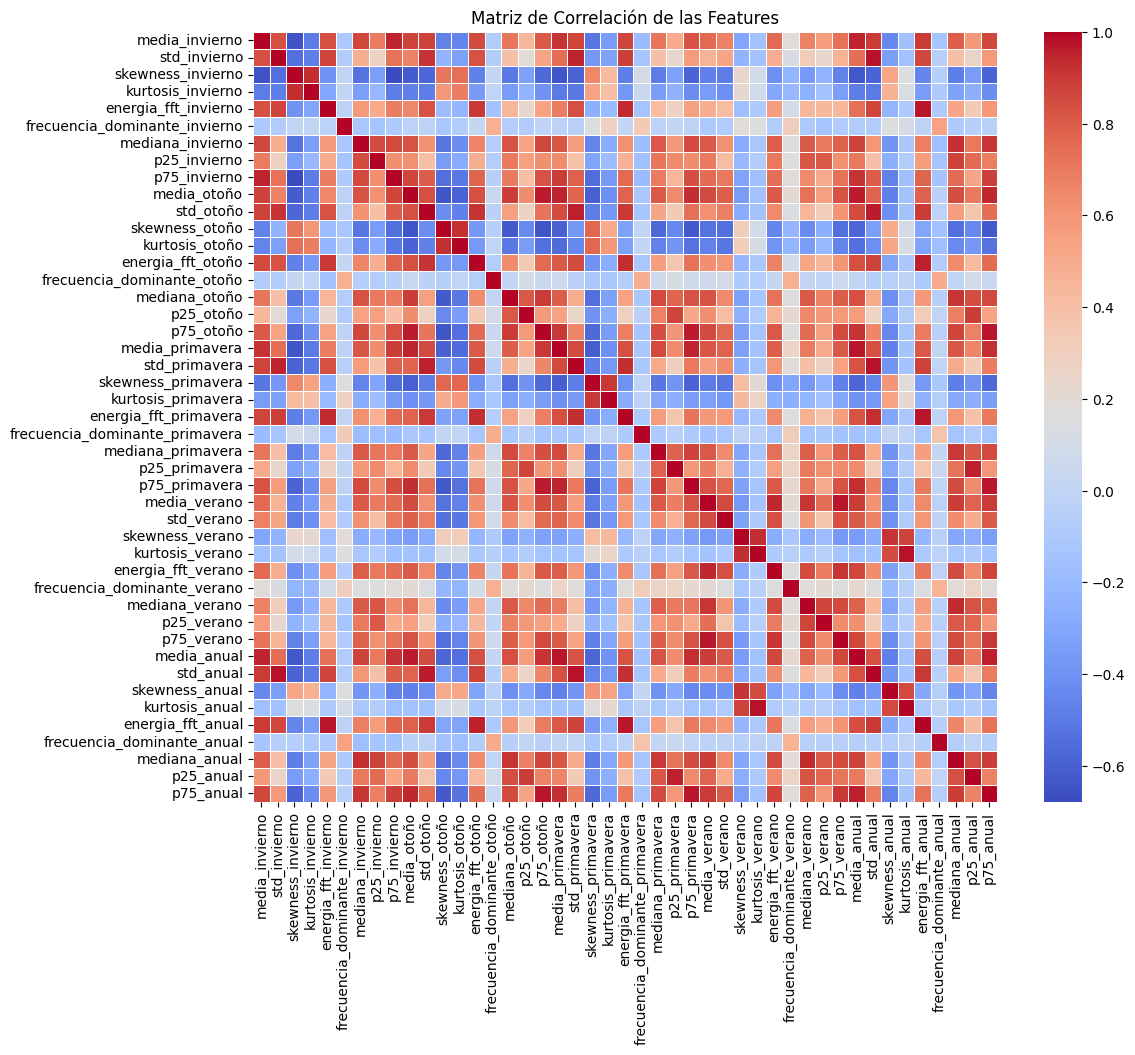


Pares de variables altamente correlacionadas (abs(corr) > 0.8):
 [('std_invierno', 'media_invierno'), ('kurtosis_invierno', 'skewness_invierno'), ('energia_fft_invierno', 'media_invierno'), ('energia_fft_invierno', 'std_invierno'), ('mediana_invierno', 'media_invierno'), ('p25_invierno', 'mediana_invierno'), ('p75_invierno', 'media_invierno'), ('p75_invierno', 'mediana_invierno'), ('media_otoño', 'media_invierno'), ('media_otoño', 'mediana_invierno'), ('media_otoño', 'p75_invierno'), ('std_otoño', 'media_invierno'), ('std_otoño', 'std_invierno'), ('std_otoño', 'energia_fft_invierno'), ('std_otoño', 'p75_invierno'), ('std_otoño', 'media_otoño'), ('kurtosis_otoño', 'skewness_otoño'), ('energia_fft_otoño', 'media_invierno'), ('energia_fft_otoño', 'std_invierno'), ('energia_fft_otoño', 'energia_fft_invierno'), ('energia_fft_otoño', 'media_otoño'), ('energia_fft_otoño', 'std_otoño'), ('mediana_otoño', 'mediana_invierno'), ('mediana_otoño', 'media_otoño'), ('p25_otoño', 'mediana_otoño'), ('

In [7]:
correlation_matrix = df_features_final.corr()

print("Matriz de Correlación:\n", correlation_matrix)

#Heatmap de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de las Features')
plt.show()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_pairs = [(column, row) for column in upper_triangle.columns for row in upper_triangle.index if abs(upper_triangle.loc[row, column]) > 0.8]

print("\nPares de variables altamente correlacionadas (abs(corr) > 0.8):\n", highly_correlated_pairs)

### Correcion de errores y NaN

In [8]:
df_drop = df_features_final.copy()
# Voy a eliminar dos filas (cups) que tienen NaN durante todo el invierno
cups_con_nan_invierno = ['ceaddbf817fc', 'd0fbcc1108d8']
df_drop.drop(index=cups_con_nan_invierno, inplace=True, errors='ignore')

# Voy a eliminar tres filas (cups) que tienen NaN durante todo el otoño
cups_con_nan_otoño = ['83c7fbada9b4', 'b476034a2e3d', 'ba38270a360e']
df_drop.drop(index=cups_con_nan_otoño, inplace=True, errors='ignore')

**Técnicas Implementadas**

### 1. KNNImputer

* **Concepto:** Imputación basada en los $k$-vecinos más cercanos ($k=5$).
* **Ventajas:**
    * Mantiene relaciones no lineales entre variables.
    * Considera la similitud entre registros completos.

### 2. SoftImpute

* **Concepto:** Imputación basada en factorización matricial (descomposición SVD).
* **Ventajas:**
    * Eficiente para matrices grandes y dispersas.
    * Maneja bien patrones de datos faltantes aleatorios.


In [9]:
# Opción 1: KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(
    knn_imputer.fit_transform(df_features_final),
    columns=df_features_final.columns,
    index=df_features_final.index
)
df_knn.to_csv("dataset/features_KNNImputer.csv")

# Opción 2: SoftImpute
soft_imputer = SoftImpute()
df_soft = pd.DataFrame(
    soft_imputer.fit_transform(df_features_final),
    columns=df_features_final.columns,
    index=df_features_final.index
)
df_soft.to_csv("dataset/features_SoftImpute.csv")

# Opción 3: Dataset original (sin imputar) para comparación
df_drop.to_csv("dataset/features_drop.csv")

[SoftImpute] Max Singular Value of X_init = 115082.524340
[SoftImpute] Iter 1: observed MAE=23.523659 rank=6
[SoftImpute] Iter 2: observed MAE=23.523622 rank=6
[SoftImpute] Iter 3: observed MAE=23.523051 rank=6
[SoftImpute] Iter 4: observed MAE=23.524372 rank=6
[SoftImpute] Iter 5: observed MAE=23.525516 rank=6
[SoftImpute] Iter 6: observed MAE=23.525970 rank=6
[SoftImpute] Iter 7: observed MAE=23.526142 rank=6
[SoftImpute] Iter 8: observed MAE=23.526207 rank=6
[SoftImpute] Stopped after iteration 8 for lambda=2301.650487


In [10]:
tiene_nans = df_knn.isnull().any().any()

if tiene_nans:

    columnas_con_nans = df_features_final.columns[df_features_final.isnull().any()].tolist()
    print(f"Las columnas con valores NaN son: {columnas_con_nans}")

    nans_por_columna = df_features_final.isnull().sum()
    print("\nNúmero de NaNs por columna:")
    print(nans_por_columna[nans_por_columna > 0])

else:
    print("El dataset no contiene ningún valor NaN.")

El dataset no contiene ningún valor NaN.


### Aqui eligimos con que dataset hacemos las cosas (por ahora KNNIMPUTER)

In [11]:
df = pd.read_csv("dataset/features_KNNImputer.csv", index_col='cups')

In [12]:
num_columnas = df.shape[1]
print(f"El DataFrame df_features_final tiene {num_columnas} columnas.")
nombres_columnas = df.columns.tolist()
print(f"Los nombres de las columnas son: {nombres_columnas}")

El DataFrame df_features_final tiene 45 columnas.
Los nombres de las columnas son: ['media_invierno', 'std_invierno', 'skewness_invierno', 'kurtosis_invierno', 'energia_fft_invierno', 'frecuencia_dominante_invierno', 'mediana_invierno', 'p25_invierno', 'p75_invierno', 'media_otoño', 'std_otoño', 'skewness_otoño', 'kurtosis_otoño', 'energia_fft_otoño', 'frecuencia_dominante_otoño', 'mediana_otoño', 'p25_otoño', 'p75_otoño', 'media_primavera', 'std_primavera', 'skewness_primavera', 'kurtosis_primavera', 'energia_fft_primavera', 'frecuencia_dominante_primavera', 'mediana_primavera', 'p25_primavera', 'p75_primavera', 'media_verano', 'std_verano', 'skewness_verano', 'kurtosis_verano', 'energia_fft_verano', 'frecuencia_dominante_verano', 'mediana_verano', 'p25_verano', 'p75_verano', 'media_anual', 'std_anual', 'skewness_anual', 'kurtosis_anual', 'energia_fft_anual', 'frecuencia_dominante_anual', 'mediana_anual', 'p25_anual', 'p75_anual']


In [13]:
columnas_invierno = [col for col in nombres_columnas if re.search(r'_invierno', col)]
columnas_primavera = [col for col in nombres_columnas if re.search(r'_primavera', col)]
columnas_verano = [col for col in nombres_columnas if re.search(r'_verano', col)]
columnas_otoño = [col for col in nombres_columnas if re.search(r'_otoño', col)]
columnas_anuales = [col for col in nombres_columnas if re.search(r'_anual', col)]

print("\nColumnas relacionadas con Invierno:")
print(len(columnas_invierno))
print(columnas_invierno)
print("\nColumnas relacionadas con Primavera:")
print(len(columnas_primavera))
print(columnas_primavera)
print("\nColumnas relacionadas con Verano:")
print(len(columnas_verano))
print(columnas_verano)
print("\nColumnas relacionadas con Otoño:")
print(len(columnas_otoño))
print(columnas_otoño)
print("\nColumnas con agregación Anual:")
print(len(columnas_anuales))
print(columnas_anuales)


Columnas relacionadas con Invierno:
9
['media_invierno', 'std_invierno', 'skewness_invierno', 'kurtosis_invierno', 'energia_fft_invierno', 'frecuencia_dominante_invierno', 'mediana_invierno', 'p25_invierno', 'p75_invierno']

Columnas relacionadas con Primavera:
9
['media_primavera', 'std_primavera', 'skewness_primavera', 'kurtosis_primavera', 'energia_fft_primavera', 'frecuencia_dominante_primavera', 'mediana_primavera', 'p25_primavera', 'p75_primavera']

Columnas relacionadas con Verano:
9
['media_verano', 'std_verano', 'skewness_verano', 'kurtosis_verano', 'energia_fft_verano', 'frecuencia_dominante_verano', 'mediana_verano', 'p25_verano', 'p75_verano']

Columnas relacionadas con Otoño:
9
['media_otoño', 'std_otoño', 'skewness_otoño', 'kurtosis_otoño', 'energia_fft_otoño', 'frecuencia_dominante_otoño', 'mediana_otoño', 'p25_otoño', 'p75_otoño']

Columnas con agregación Anual:
9
['media_anual', 'std_anual', 'skewness_anual', 'kurtosis_anual', 'energia_fft_anual', 'frecuencia_dominant

Falta poir quitar las ultimas dos cups que no tienen datos de invierno por ahora
luego normalizar los datos
luego aplicar kmeans y por metedos de sacar k

### StandardScaler

StandardScaler, es una técnica fundamental de preprocesamiento de datos utilizada en machine learning, especialmente antes de aplicar algoritmos sensibles a la escala de las características (features). Su objetivo principal es transformar las características de manera que tengan una media de 0 y una desviación estándar de 1.

**La Fórmula Matemática:**

Para cada valor \(x_i\) de una característica dada, StandardScaler aplica la siguiente fórmula:

$$
z_i = \frac{x_i - \mu}{\sigma}
$$

Donde:

* \(z_i\) es el valor escalado (el z-score) del dato \(x_i\).
* \(x_i\) es el valor original del dato.
* \(\mu\) (mu) es la media de todos los valores de esa característica en el conjunto de entrenamiento.
* \(\sigma\) (sigma) es la desviación estándar de todos los valores de esa característica en el conjunto de entrenamiento.

In [14]:
features = df.values

scaler = StandardScaler()

scaled_features = scaler.fit_transform(features)

df_scaled_features = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

df_scaled_features.to_csv("dataset/features_StandardScaler.csv")

In [15]:
df = pd.read_csv("dataset/features_StandardScaler.csv", index_col='cups')

## Selección del Número de Clusters (K)

La elección del número óptimo de clusters (K) es un paso crucial en el algoritmo K-Means. Un valor de K demasiado bajo puede agrupar datos inherentemente distintos, mientras que un valor demasiado alto puede dividir clusters significativos o crear clusters con muy pocos miembros.

En este análisis, evaluamos varios valores de K dentro de un rango predefinido (2 a 20) utilizando las siguientes métricas:

* **Índice de Silueta:** Evalúa qué tan bien cada punto se ajusta a su propio cluster en comparación con otros clusters. Varía de -1 a 1, donde:
    * 1 indica que el punto está bien agrupado.
    * 0 indica que el punto está cerca del límite de decisión entre dos clusters.
    * -1 indica que el punto podría estar mejor en el cluster vecino.

* **Índice de Davies-Bouldin (DBI):** Mide la similitud promedio entre cada cluster y su cluster "más similar". Un DBI más bajo indica una mejor separación entre clusters.

* **Clusters Irrelevantes:** Contamos el número de clusters cuyo tamaño es menor que un umbral definido (5% del total de datos). Estos clusters pequeños pueden indicar un sobreajuste o ruido en los datos.

**Metodología:**

1.  **Carga de Datos:** Se carga el dataset preprocesado y escalado (StandardScaler).
2.  **Iteración sobre Valores de K:** Para cada valor de K en el rango especificado:
    * Se instancia y entrena un modelo KMeans con el valor de K actual.
    * Se obtienen las etiquetas de los clusters y los centroides.
    * Se calculan las métricas MAE, Índice de Silueta y DBI.
    * Se cuenta el número de clusters irrelevantes.
3.  **Almacenamiento de Resultados:** Los valores de K y las métricas correspondientes se guardan en archivos pickle para su posterior análisis o visualización.

**Interpretación de las Métricas:**

* Se busca un valor de K que minimice el DBI, y maximice el Índice de Silueta.
* Un número elevado de clusters irrelevantes sugiere que K es demasiado grande.
* El Índice de Silueta cercano a 1 indica que los clusters están bien separados.
* El Índice de Davies-Bouldin bajo indica que los clusters son distintos y compactos.

### ¿Cómo funciona el **clustering espectral**?

1. **Matriz de similitud (afinidad):**  
   Se construye una matriz `S` donde cada elemento \( S_{ij} \) representa la similitud entre la vivienda \( i \) y la \( j \).  
   Esto se puede calcular, por ejemplo, con:
   - **RBF kernel (gaussiano):**
     \[
     S_{ij} = \exp\left(-\frac{||x_i - x_j||^2}{2\sigma^2}\right)
     \]

2. **Matriz Laplaciana:**  
   A partir de la matriz de similitud \( S \), se construye la matriz Laplaciana:
   \[
   L = D - S
   \]
   o bien la versión normalizada:
   \[
   L_{\text{sym}} = D^{-1/2} L D^{-1/2}
   \]
   donde \( D \) es la matriz diagonal de grados, con \( D_{ii} = \sum_j S_{ij} \).

3. **Descomposición espectral:**  
   Se calculan los **autovectores** asociados a los menores **autovalores** de la matriz Laplaciana.  
   Estos vectores forman una nueva representación de menor dimensión del conjunto de datos.

4. **Clustering sobre el espacio espectral:**  
   Finalmente, se aplica **K-means** sobre las filas de esta nueva matriz espectral.  
   Cada fila representa una vivienda transformada en este nuevo espacio de características, donde las relaciones de similitud son más evidentes.

### ¿Por qué usar **clustering espectral** en lugar de solo K-means?

Porque el clustering espectral:

- **No asume formas esféricas** ni separación lineal entre clústeres.
- Puede capturar **relaciones no lineales** complejas en los datos.
- Es ideal cuando:
  - Hay **clases que se solapan** parcialmente.
  - Existen **patrones temporales no triviales** (como en series de consumo eléctrico).
  - Los clústeres tienen **formas irregulares o extendidas**.


In [16]:
X = df.values

param_grid = {
    'n_clusters': list(range(2, 30)),
    'affinity': ['rbf'],
    'gamma': [0.5, 1, 2],
}

results = []

for gamma in param_grid['gamma']:
    for k in param_grid['n_clusters']:
        try:
            model = SpectralClustering(
                n_clusters=k,
                affinity='rbf',
                gamma=gamma,
                assign_labels='kmeans',
                random_state=42
            )
            labels = model.fit_predict(X)
            
            silhouette = silhouette_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)
            
            results.append({
                'n_clusters': k,
                'affinity': 'rbf',
                'gamma': gamma,
                'silhouette': silhouette,
                'davies_bouldin_score': davies_bouldin
            })
        except Exception as e:
            print(f"Error con rbf, k={k}, gamma={gamma}: {e}")



In [17]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='silhouette', ascending=False).head())


    n_clusters affinity  gamma  silhouette  davies_bouldin_score
0            2      rbf    0.5    0.592835              0.294085
66          12      rbf    2.0    0.592835              0.294085
61           7      rbf    2.0    0.592835              0.294085
28           2      rbf    1.0    0.592835              0.294085
81          27      rbf    2.0    0.592835              0.294085


In [18]:
print(results_df.sort_values(by='davies_bouldin_score', ascending=True).head())

    n_clusters affinity  gamma  silhouette  davies_bouldin_score
29           3      rbf    1.0    0.581774              0.261824
30           4      rbf    1.0    0.581774              0.261824
31           5      rbf    1.0    0.581774              0.261824
46          20      rbf    1.0    0.581774              0.261824
37          11      rbf    1.0    0.581774              0.261824


In [19]:
X = df.values

param_grid = {
    'n_clusters': list(range(2, 30)),
    'affinity': ['nearest_neighbors'],
    'n_neighbors': [5, 10, 15, 20, 25, 30]
}

results = []

for n_neighbors in param_grid['n_neighbors']:
    for k in param_grid['n_clusters']:
        try:
            model = SpectralClustering(
                n_clusters=k,
                affinity='nearest_neighbors',
                n_neighbors=n_neighbors,
                assign_labels='kmeans',
                random_state=42
            )
            labels = model.fit_predict(X)
            
            silhouette = silhouette_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)
            
            results.append({
                'n_clusters': k,
                'affinity': 'nearest_neighbors',
                'n_neighbors': n_neighbors,
                'silhouette': silhouette,
                'davies_bouldin_score': davies_bouldin
            })
        except Exception as e:
            print(f"Error con nearest_neighbors, k={k}, gamma={gamma}: {e}")



In [20]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='silhouette', ascending=False).head())


     n_clusters           affinity  n_neighbors  silhouette  \
84            2  nearest_neighbors           20    0.305627   
56            2  nearest_neighbors           15    0.303173   
140           2  nearest_neighbors           30    0.294238   
112           2  nearest_neighbors           25    0.276136   
28            2  nearest_neighbors           10    0.246102   

     davies_bouldin_score  
84               1.242926  
56               1.247063  
140              1.261191  
112              1.294044  
28               1.358231  


In [21]:
print(results_df.sort_values(by='davies_bouldin_score', ascending=True).head())

     n_clusters           affinity  n_neighbors  silhouette  \
165          27  nearest_neighbors           30    0.097015   
138          28  nearest_neighbors           25    0.075449   
137          27  nearest_neighbors           25    0.084993   
136          26  nearest_neighbors           25    0.077219   
79           25  nearest_neighbors           15    0.098408   

     davies_bouldin_score  
165              1.166483  
138              1.171569  
137              1.179437  
136              1.224441  
79               1.236506  


### Mejor Configuración de Hiperparámetros

| N° Clusters | Afinidad | Gamma | Silhouette Score  | Davies-Bouldin Score  |
|-------------|----------|-------|-------------------|-----------------------|
| 12          | rbf      | 2.0   | 0.593             | 0.22940859            |
| 7           | rbf      |  2.0  | 0.592835          | 0.294085              |

### Interpretación de Métricas

#### Silhouette Score (0.593)
- **Rango óptimo**: [0.5, 1.0]
- **Interpretación**: 
  - Estructura de clusters significativa
  - Los clusters están razonablemente separados
  - Los puntos están bien asignados a sus clusters

#### Davies-Bouldin Score (0.294)
- **Rango óptimo**: [0, 1] (menor es mejor)
- **Interpretación**:
  - Excelente separación entre clusters
  - Los centroides están bien distanciados
  - Resultado sobresaliente (valores < 0.5 son considerados buenos)

## Aplicación de Clustering Spectral con el Número Óptimo de Clusters

In [ ]:
best_k = 7
gamma = 2.0

sc_final = SpectralClustering(
                n_clusters=k,
                affinity='rbf',
                gamma=gamma,
                random_state=42
            )
sc_final.fit(X)

labels = sc_final.fit_predict(X)

centroids = np.array([X[labels == i].mean(axis=0) for i in range(best_k)])

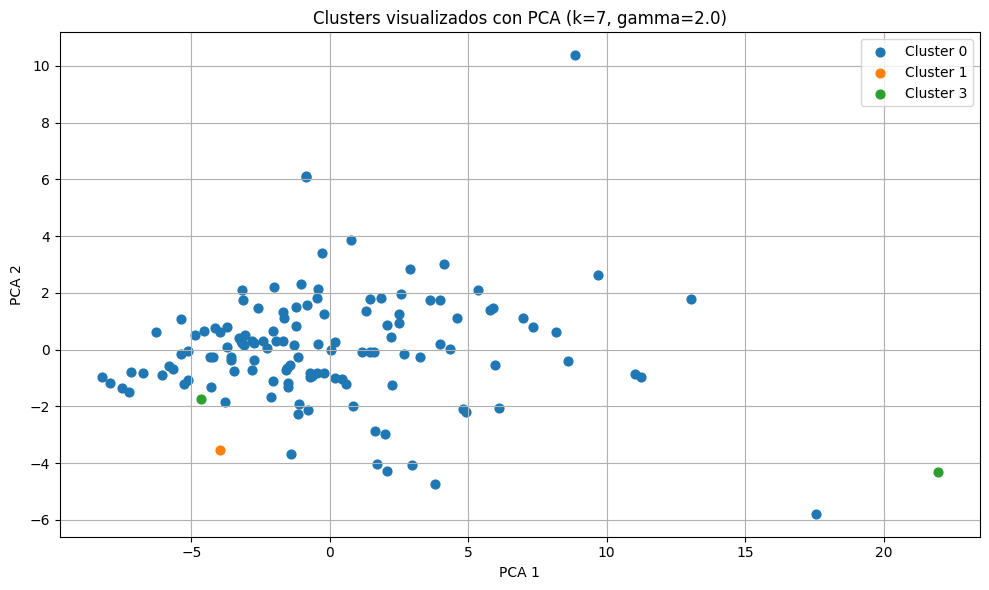

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducción a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot con etiquetas de cluster
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(labels):
    idx = labels == cluster_id
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Cluster {cluster_id}', s=40)

plt.title(f"Clusters visualizados con PCA (k={best_k}, gamma={gamma})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


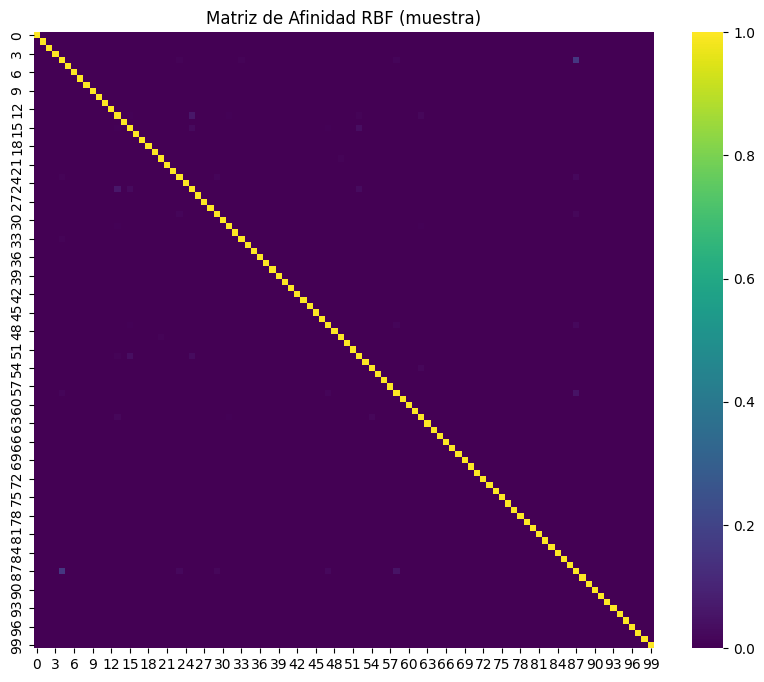

In [25]:
import seaborn as sns

# Obtener la matriz de afinidad (requiere acceso a la matriz subyacente)
# Nota: Esto puede no estar disponible directamente en SpectralClustering
# Alternativa: calcular manualmente una matriz de similaridad RBF
from sklearn.metrics.pairwise import rbf_kernel
affinity_matrix = rbf_kernel(X, gamma=gamma)

plt.figure(figsize=(10, 8))
sns.heatmap(affinity_matrix[:100, :100], cmap='viridis')  # Muestra solo 100x100 para claridad
plt.title('Matriz de Afinidad RBF (muestra)')
plt.show()

## Guardar el Modelo Final

In [26]:
with open("pkls/sc_24h_model_watts.pkl", "wb") as f:
    pickle.dump(sc_final, f)

### Variables más influyentes según varianza entre clusters

In [27]:
centroides = pd.DataFrame(
    centroids,
    columns=df_features_final.columns
)

variabilidad = centroides.var(axis=0).sort_values(ascending=False)
print(variabilidad)

kurtosis_anual                    39.275995
kurtosis_verano                   34.379154
skewness_verano                   22.531936
skewness_anual                    21.055986
p25_verano                         6.748265
p25_invierno                       5.165852
mediana_anual                      3.364323
mediana_verano                     3.299286
mediana_invierno                   3.104064
energia_fft_verano                 2.462788
energia_fft_invierno               2.134228
energia_fft_anual                  2.013622
media_invierno                     1.911856
media_verano                       1.790445
p75_invierno                       1.586211
media_anual                        1.527619
p75_anual                          1.397613
energia_fft_otoño                  1.290752
p25_anual                          1.166995
p75_verano                         0.953254
mediana_otoño                      0.933830
p75_otoño                          0.889433
energia_fft_primavera           

## Visualización de Resultados de Clustering

In [28]:
cluster_colors = cm.get_cmap('tab10', best_k)

### Visualización de Clusters PCA

In [29]:
# Reducir a 2D para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centroids_pca = pca.transform(centroids)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### 1. PCA 2D

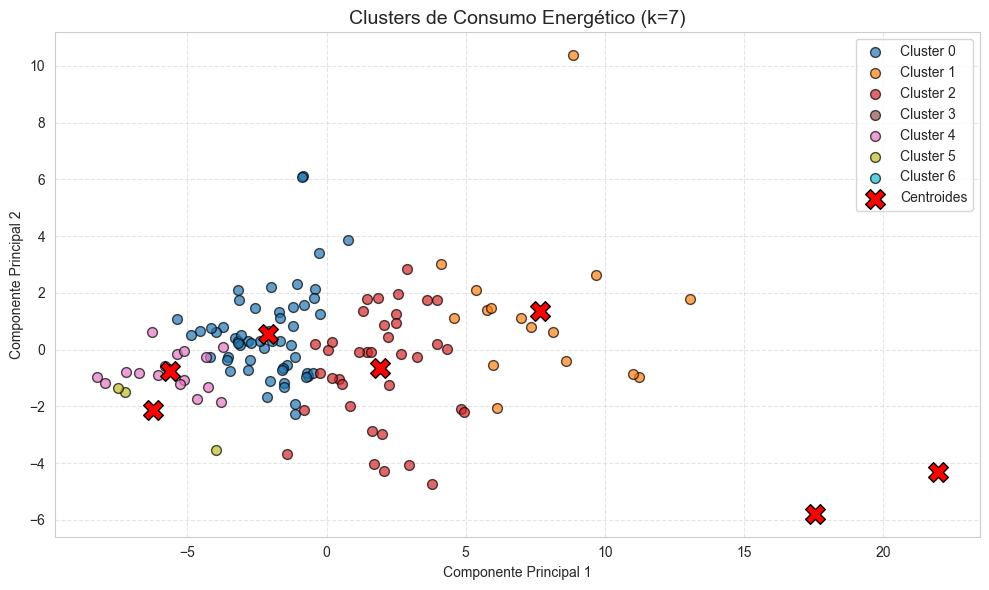

In [ ]:
plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    plt.scatter(
        X_pca[labels == cluster, 0],
        X_pca[labels == cluster, 1],
        label=f'Cluster {cluster}',
        color=cluster_colors(cluster),
        alpha=0.7,
        edgecolor='k',
        s=50
    )

# Centroides
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker='X',
    s=200,
    c='red',
    edgecolor='k',
    label='Centroides'
)

plt.title(f'Clusters de Consumo Energético (k={best_k})', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 2. PCA 3D

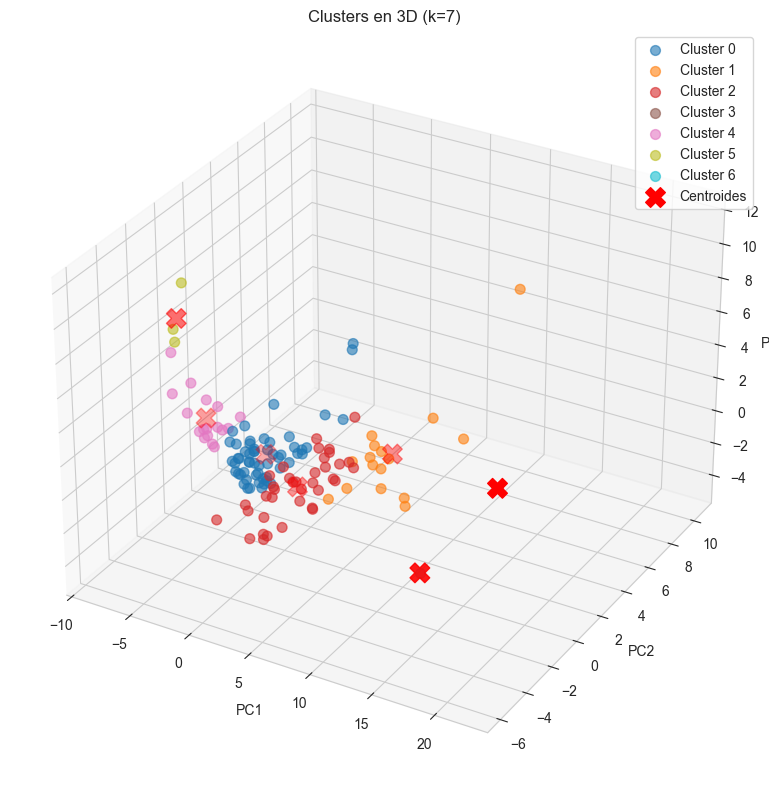

In [ ]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)
centroids_pca_3d = pca_3d.transform(centroids)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(best_k):
    ax.scatter(
        X_pca_3d[labels == cluster, 0],
        X_pca_3d[labels == cluster, 1],
        X_pca_3d[labels == cluster, 2],
        label=f'Cluster {cluster}',
        color=cluster_colors(cluster),
        alpha=0.6,
        s=50
    )

ax.scatter(
    centroids_pca_3d[:, 0],
    centroids_pca_3d[:, 1],
    centroids_pca_3d[:, 2],
    marker='X',
    s=200,
    c='red',
    label='Centroides'
)

ax.set_title(f'Clusters en 3D (k={best_k})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.tight_layout()
plt.show()

### Visualización de Clusters de su Consumo Original

In [ ]:
df_original = pd.read_csv("../../../data/vertical_preprocessed_data_2.csv", sep=";")

cups_con_nan_invierno = ['ceaddbf817fc', 'd0fbcc1108d8']
df_original = df_original[~df_original['cups'].isin(cups_con_nan_invierno)]

cups_con_nan_otoño = ['83c7fbada9b4', 'b476034a2e3d', 'ba38270a360e']
df_original = df_original[~df_original['cups'].isin(cups_con_nan_otoño)]


df_clusters = df_features_final.reset_index()[['cups']].copy()
df_clusters['cluster'] = labels


df_final = pd.merge(df_original, df_clusters[['cups', 'cluster']], on='cups', how='left')

# Reordenar las columnas para que 'cluster' sea la segunda
column_order = ['cups', 'cluster'] + [col for col in df_final.columns if col not in ['cups', 'cluster']]
df_final = df_final[column_order]

df_final.to_csv('dataset/datos_consumo_con_clusters.csv', index=False, sep=';')

### 1. Distribución de Series por Cluster

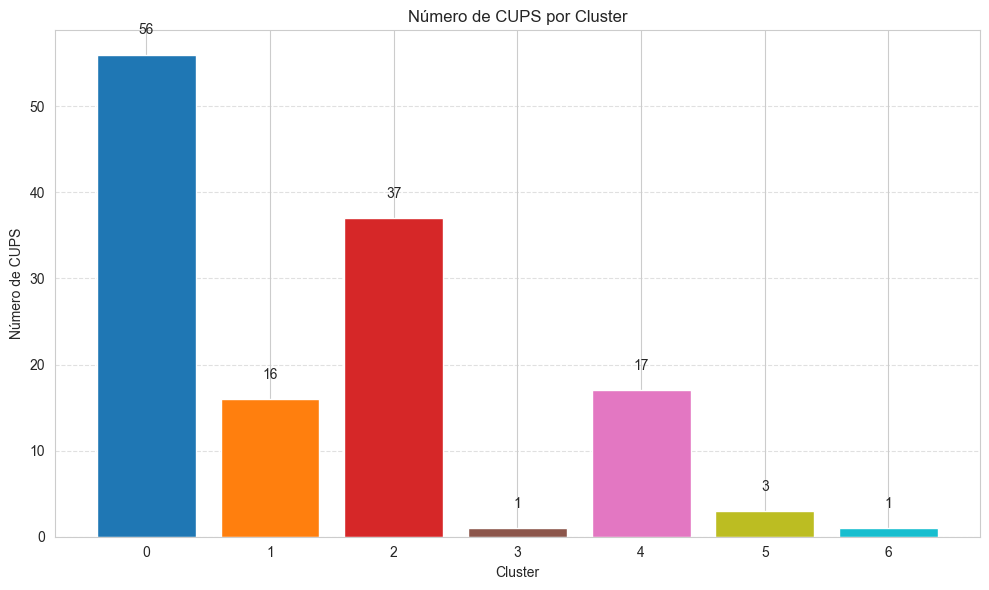

In [ ]:
cluster_counts = df_clusters['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(
    cluster_counts.index.astype(int),
    cluster_counts.values,
    color=[cluster_colors(int(i)) for i in cluster_counts.index]
)

plt.title('Número de CUPS por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de CUPS')
plt.xticks(cluster_counts.index.astype(int))
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 2,
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

### 2. Superposición de Series con Centroides

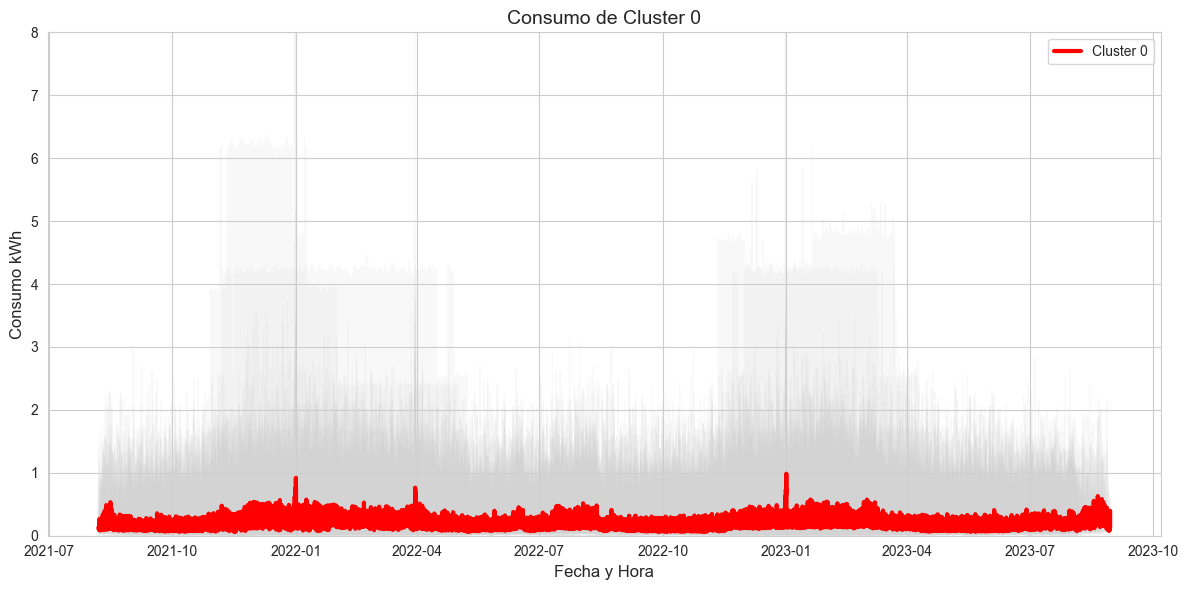

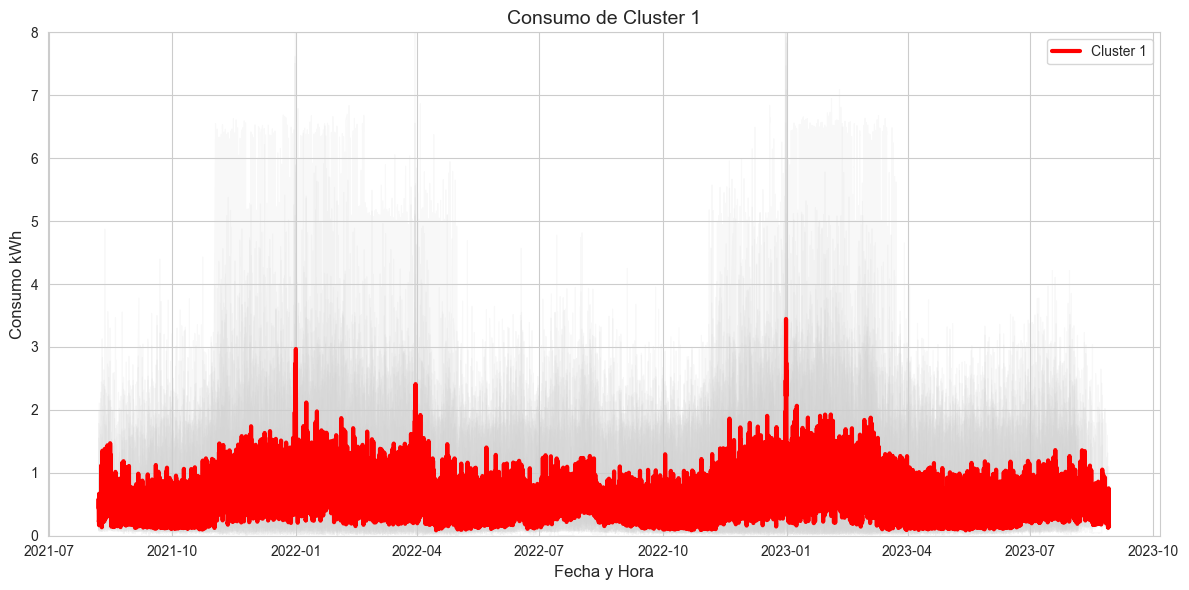

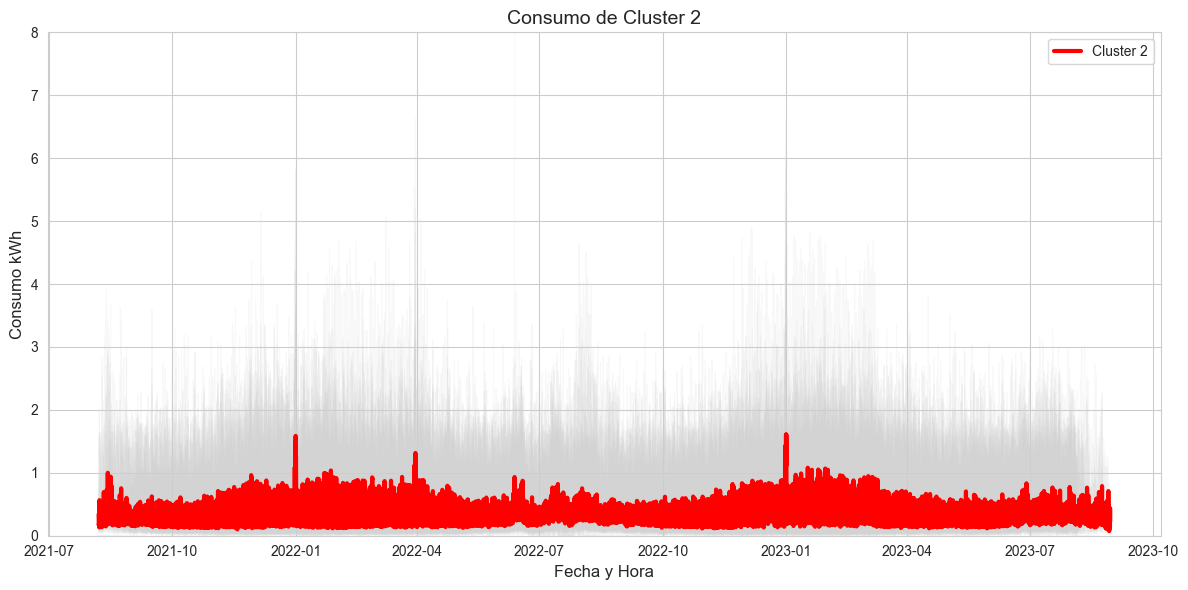

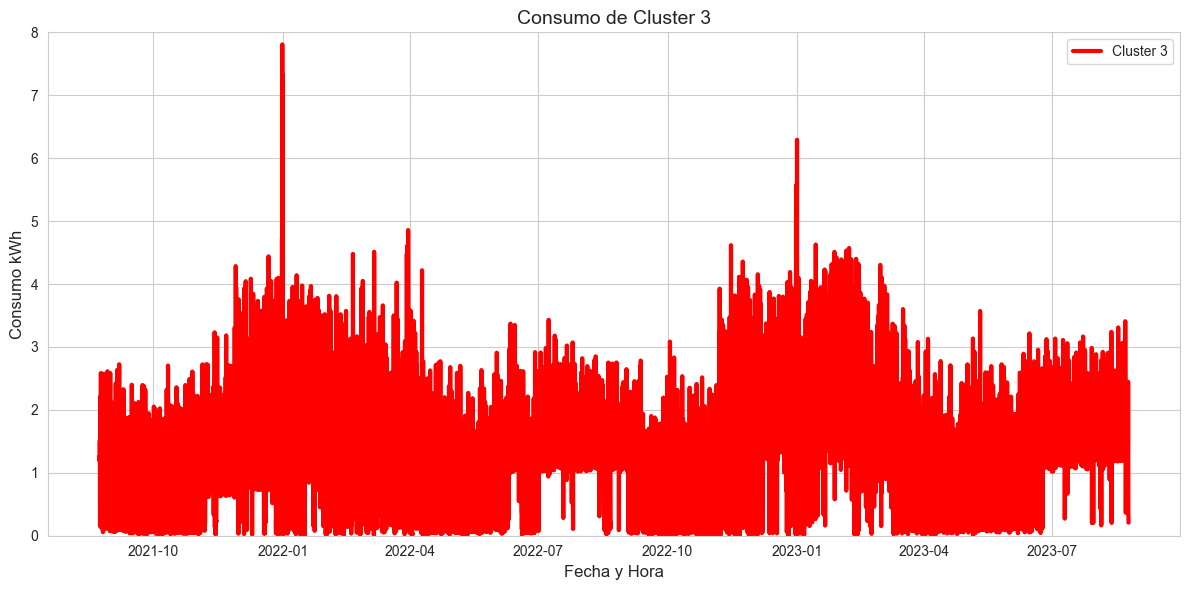

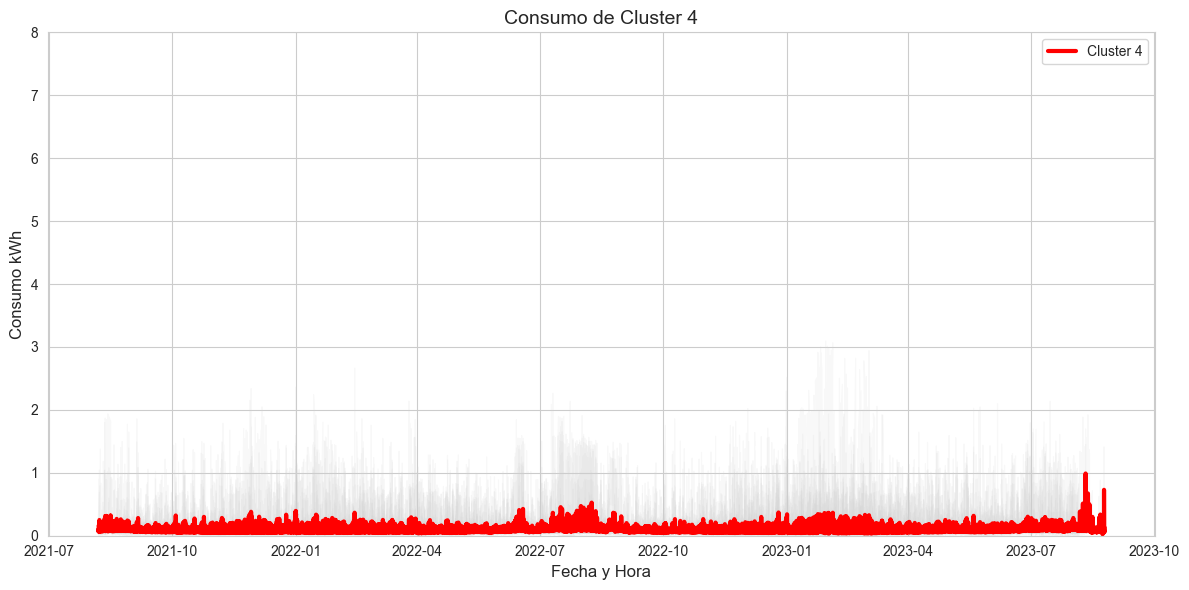

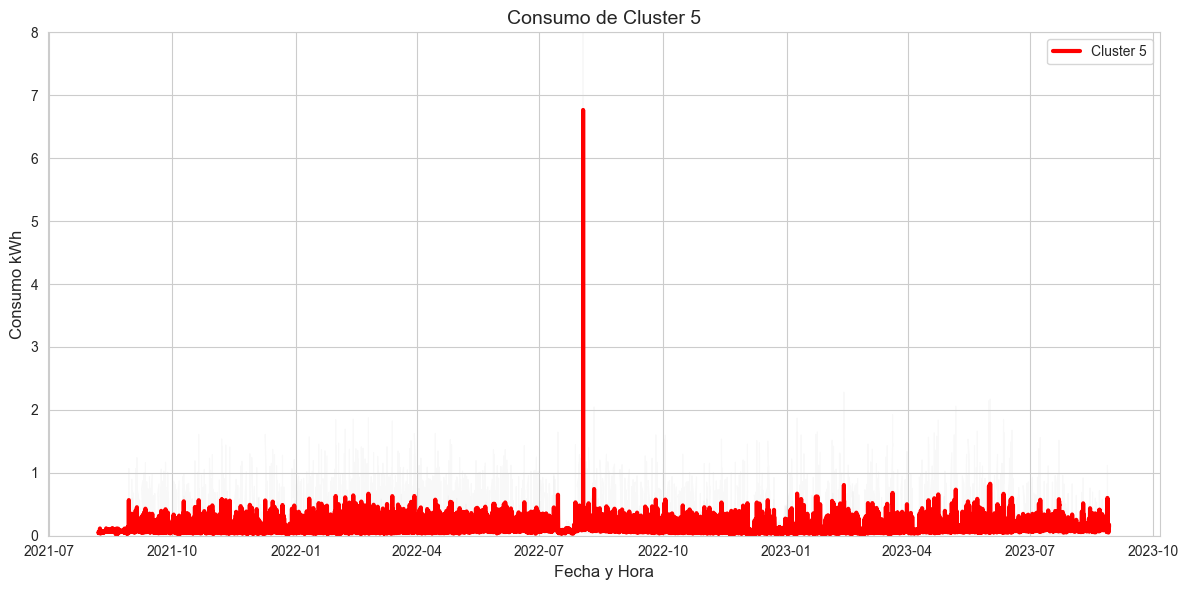

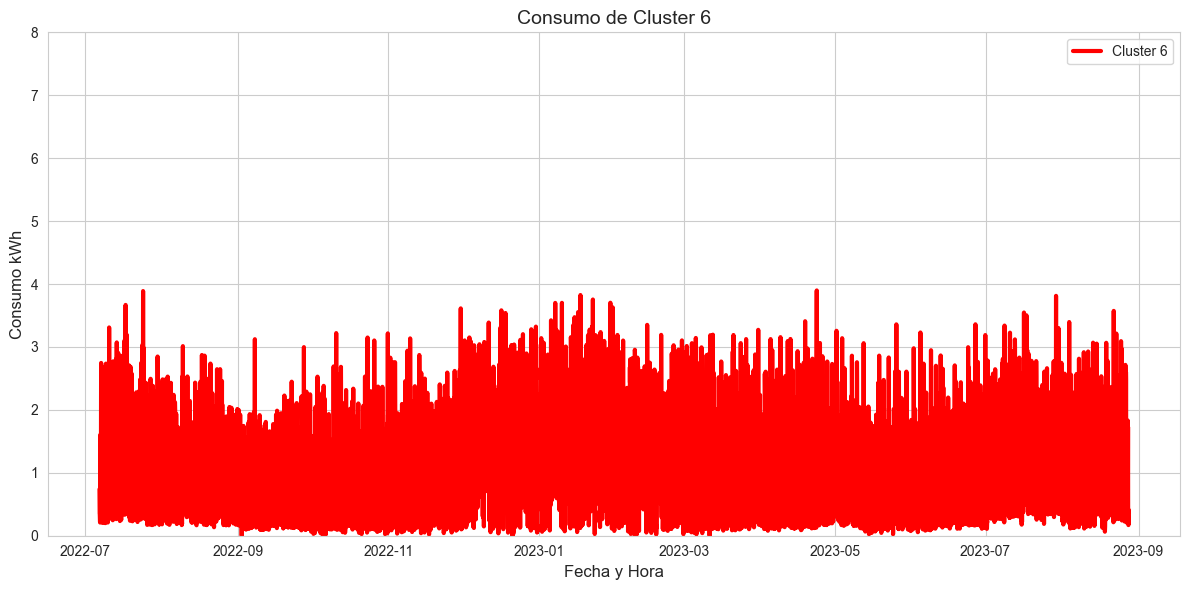

In [ ]:
df = pd.read_csv("dataset/datos_consumo_con_clusters.csv", sep=';')

df['hora'] = df['hora'].astype(int)

df['datetime'] = pd.to_datetime(df['fecha']) + pd.to_timedelta(df['hora'], unit='h')

clusters = sorted(df['cluster'].unique())

for cluster in clusters:
    plt.figure(figsize=(12, 6))

    cluster_data = df[df['cluster'] == cluster]
    
    for cups_id in cluster_data['cups'].unique():
        cups_series = cluster_data[cluster_data['cups'] == cups_id]
        plt.plot(cups_series['datetime'], cups_series['consumo_kWh'], color='lightgray', alpha=0.15, linewidth=0.8)
    
    cluster_center = cluster_data.groupby('datetime')['consumo_kWh'].mean()
    plt.plot(cluster_center.index, cluster_center.values, label=f'Cluster {int(cluster)}', linewidth=3, color='red')

    plt.title(f'Consumo de Cluster {int(cluster)}', fontsize=14)
    plt.xlabel('Fecha y Hora', fontsize=12)
    plt.ylabel('Consumo kWh', fontsize=12)
    plt.grid(True)
    plt.legend()
    
    # Fijar el rango del eje Y de 0 a 8 kWh
    plt.ylim(0, 8)
    
    plt.tight_layout()
    plt.show()
